In [2]:
import numpy as np
import scipy.signal
from matplotlib import pyplot as plt
import lal
import lalsimulation

In [3]:
import os
os.environ["LAL_DATA_PATH"] = "/home/max.isi/lscsoft/opt/lalsuite-extra/share/lalsimulation/"

In [4]:
np.random.seed()

# Simulate data

In [5]:
ifos = ['H1', 'L1', 'V1', 'K1']

# export settings (doesn't save if False)
export_path = 'simulated_data_design_scalar_1024KHz_256s_%s.txt.gz'

# optionally, condition to mimic GWOSC processing
decimate_factor = 2
fbp_min = None
fbp_max = None

# if injecting, epoch is set such that times are centered on t_inject
t_inject = 1126259462.
epoch = None
window_injection = True

fmin  = 5
fmax = 2048
duration = 256

seed = None

##############

delta_t = 1.0 / (2. * fmax)
delta_f = 1.0 / duration

fmin = fmin or delta_f

flen = int(fmax/delta_f) + 1

## Noise

Create frequency domain noise from PSD.

In [6]:
# TODO: use PSD from https://dcc.ligo.org/T1800044-v5
psd_func_dict = {
    'H1': lalsimulation.SimNoisePSDaLIGOZeroDetHighPower,
    'L1': lalsimulation.SimNoisePSDaLIGOZeroDetHighPower,
    'V1': lalsimulation.SimNoisePSDAdvVirgo,
    'K1': lalsimulation.SimNoisePSDaLIGOZeroDetHighPower,
}

In [7]:
frequencies = np.arange(flen)*delta_f

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(frequencies))
    for i,f in enumerate(frequencies):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = 0.
    psd_dict[ifo] = psd

In [8]:
np.random.seed(seed)

noise_fd_dict = {}

for ifo,psd in psd_dict.items():
    var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = np.random.normal(size=len(frequencies), loc=0, scale=np.sqrt(var))
    noise_imag = np.random.normal(size=len(frequencies), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag
    

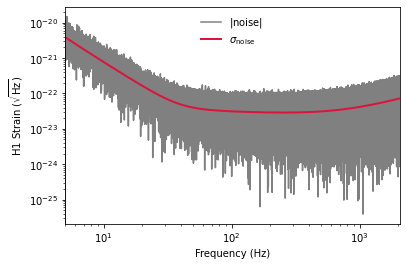

In [9]:
# plot first ifo as a check

ifo_ref = ifos[0]
noise_fd = noise_fd_dict[ifo_ref]
var = psd_dict[ifo_ref] / (4.*delta_f)

plt.loglog(frequencies, np.absolute(noise_fd), label=r'$|\mathrm{noise}|$', c='gray')
plt.loglog(frequencies, np.sqrt(var), label=r'$\sigma_\mathrm{noise}$', c='crimson', lw=2)
plt.legend(loc='upper center', frameon=False)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"%s Strain ($\sqrt{\mathrm{Hz}}$)" % ifo_ref)
plt.xlim(fmin, fmax)
plt.show()

IFFT into the time domain. (This might take some time.)

In [10]:
fft_norm = delta_t

noise_td_dict = {}
for ifo,noise_fd in noise_fd_dict.items():
    noise_td_dict[ifo] = np.fft.irfft(noise_fd) / fft_norm

In [11]:
# create time array centered on injection time
# unless epoch was given explicitly

tlen = len(noise_td_dict[ifos[0]])
if epoch is None:
    epoch = (t_inject - 0.5*tlen*delta_t)

times = np.arange(tlen)*delta_t + epoch

if t_inject is not None:
    times -= ((epoch - t_inject) % delta_t)
    print("Injection time in array: %r" % (t_inject in times))

Injection time in array: True


In [12]:
# check normalization
# the integral of the PSD should be equal to the variance
# https://cran.r-project.org/web/packages/psd/vignettes/normalization.pdf

for ifo, noise in noise_td_dict.items():
    print(ifo, np.sum(psd_dict[ifo])*delta_f, np.std(noise)**2)

H1 3.9737805920737185e-43 3.905094362849121e-43
L1 3.9737805920737185e-43 4.355304875160232e-43
V1 3.840459542829127e-40 3.86390878286141e-40
K1 3.9737805920737185e-43 4.068649541242453e-43


0.9989993577483508 0.9982872854187165 0.9986442103786426


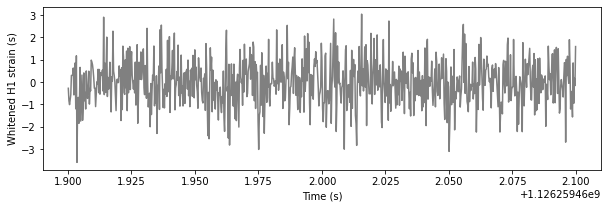

0.9975314828885093 0.9968923377369652 0.9972124343623038


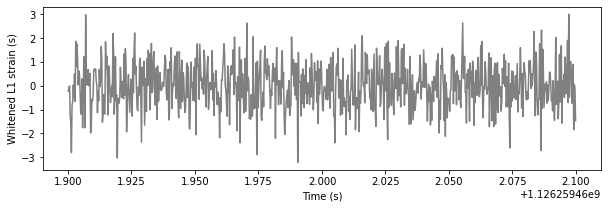

0.9992579066081618 0.998523127303018 0.9988934356568647


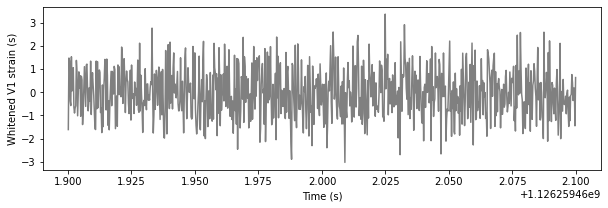

0.9973685245198013 0.9986891791418725 0.9980276584084181


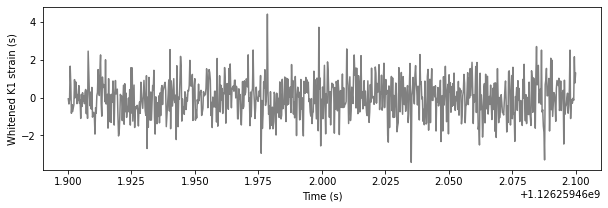

In [13]:
t_mask = (t_inject - 0.1 <= times) & (times <= t_inject + 0.1)

for ifo, data_fd in noise_fd_dict.items():
    psd = psd_dict[ifo]
    psd[psd == 0] = np.inf
    data_fd_white = np.sqrt(4*delta_f/psd) * data_fd
     # TODO: why is this the right norm below?
    data_td_white = np.fft.irfft(data_fd_white)*np.sqrt(0.5*tlen)
    print(np.std(data_fd_white.real), np.std(data_fd_white.imag), np.std(data_td_white))
    fig, ax = plt.subplots(1, figsize=(10, 3))
    ax.plot(times[t_mask], data_td_white[t_mask], c='gray')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Whitened %s strain (s)' % ifo)
    plt.show()

In [15]:
# import pycbc.noise
# import pycbc.psd

# # Noise parameters
# flow  = fmin
# fhigh  = fmax
# duration = 64
# seed = 123


# # Filter settings (also used for PSD truncation)
# fir_flow = 20
# fir_knee = 512

# # Use PyCBC to produce aLIGO noise time series
# delta_f = 1.0 / duration
# flen = int(fhigh / delta_f) + 1
# psd_pycbc = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# delta_t = 1.0 / (2. * fhigh)  # Nyquist
# tlen = int(duration/delta_t) + 1
# noise_pycbc = pycbc.noise.noise_from_psd(tlen - 1, delta_t, psd_pycbc)#, seed=123)

# data_pycbc = noise_pycbc.data
# time_pycbc = noise_pycbc.sample_times

## Signal

In [16]:
# import pycbc.waveform 

# m = 36  # Solar masses
# distance = 440  # Mpc
# hp, hc = pycbc.waveform.get_td_waveform(approximant="NRSur7dq4",
#                                         delta_t=delta_t, f_lower=10,
#                                         mass1=m, mass2=m, distance=distance)

In [14]:
# utilities from https://git.ligo.org/waveforms/reviews/nrsur7dq4/blob/master/utils.py
# and from Carl
lalsim = lalsimulation

def change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1, m2, f_ref, phi_orb=0.):
    iota, S1x, S1y, S1z, S2x, S2y, S2z = lalsim.SimInspiralTransformPrecessingNewInitialConditions(
                                             theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2,
                                             m1*lal.MSUN_SI, m2*lal.MSUN_SI, f_ref, phi_orb)
    spin1 = [S1x, S1y, S1z]
    spin2 = [S2x, S2y, S2z]
    return spin1, spin2, iota

def set_single_mode(params, l, m):
    """ Sets modes in params dict.
        Only adds (l,m) and (l,-m) modes.
    """
    # First, create the 'empty' mode array
    ma = lalsimulation.SimInspiralCreateModeArray()
    # add (l,m) and (l,-m) modes
    lalsimulation.SimInspiralModeArrayActivateMode(ma, l, m)
    lalsimulation.SimInspiralModeArrayActivateMode(ma, l, -m)    
    # then insert the ModeArray into the LALDict params
    lalsimulation.SimInspiralWaveformParamsInsertModeArray(params, ma)
    return params

def generate_lal_waveform(approximant_key, m1_msun, m2_msun, chi1, chi2, dist_mpc=1,
                          dt=None, f_low=20, f_ref=20, inclination=0, phi_ref=0.,
                          ell_max=None, single_mode=None, epoch=0):

    approximant = lalsim.SimInspiralGetApproximantFromString(approximant_key)

    m1_kg = m1_msun*lal.MSUN_SI
    m2_kg = m2_msun*lal.MSUN_SI
    
    distance = dist_mpc*1e6*lal.PC_SI

    if single_mode is not None and ell_max is not None:
        raise Exception("Specify only one of single_mode or ell_max")

    param_dict = lal.CreateDict()

    if ell_max is not None:
        # If ell_max, load all modes with ell <= ell_max
        ma = lalsim.SimInspiralCreateModeArray()
        for ell in range(2, ell_max+1):
            lalsim.SimInspiralModeArrayActivateAllModesAtL(ma, ell)
        lalsim.SimInspiralWaveformParamsInsertModeArray(param_dict, ma)
    elif single_mode is not None:
        # If a single_mode is given, load only that mode (l,m) and (l,-m)
        param_dict = set_single_mode(param_dict, single_mode[0], single_mode[1])

    hp, hc = lalsim.SimInspiralChooseTDWaveform(m1_kg, m2_kg,
                                                chi1[0], chi1[1], chi1[2],
                                                chi2[0], chi2[1], chi2[2],
                                                distance, inclination,
                                                phi_ref, 0, 0, 0,
                                                dt, f_low, f_ref,
                                                param_dict,
                                                approximant)
    h = np.array(hp.data.data - 1.j*hc.data.data)

    return h


Set injection parameters:

In [15]:
# GW150914 parameters from PE run:
# https://ldas-jobs.ligo.caltech.edu/~bfarr/offline_pe/ER8/IMRPhenomPv2/1126259462.39-0/H1L1/posplots.html

m1 = 38.2393997234
m2 = 30.6731714161
a1 = 0.883858533671
a2 = 0.486149430116
phi_jl = 6.23893429974
tilt1 = 1.67253178352
tilt2 = 1.65880670543
phi12 = 4.19940827211
theta_jn = 2.66654569575

f_ref = 20.0
phi_orb = 2.41342424662

ra = 1.952318922
dec = -1.26967171703
psi = 0.824043851821
distance = 463.870985758 # Mpc

chi1, chi2, iota = change_spin_convention(theta_jn, phi_jl, tilt1, tilt2, phi12, a1, a2, m1, m2, f_ref, phi_orb)

In [16]:
np.cos(iota), np.cos(theta_jn)

(-0.8678672843876902, -0.8892712450171797)

Generate tensor waveform:

Target peak time is 0.00e+00 away from target.


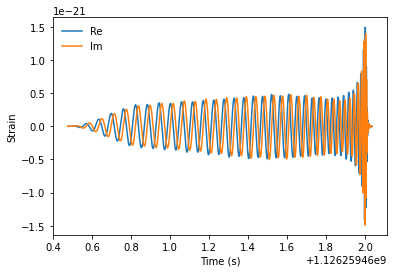

In [17]:
if t_inject is not None:
    # Note: `f_low=0` returns the surrogate from the lowest-possible frequency (not 0 Hz)
    h = generate_lal_waveform('NRSur7dq2', m1, m2, chi1, chi2, dist_mpc=distance,
                              dt=delta_t, f_low=0, f_ref=f_ref, inclination=iota,
                              phi_ref=0., ell_max=None, single_mode=(2,2), epoch=epoch)
    
    if window_injection:
        # smoothly turn on waveform
        window = scipy.signal.tukey(len(h))
        window[int(0.5*len(h)):] = 1.
        h *= window
    
    # place in array such that peak is aligned with `time_inject`
    t_peak_idx = np.argmax(np.absolute(h))
    t_inject_idx = np.argmin(np.abs(times - t_inject))
    print("Target peak time is %.2e away from target." % (times[t_inject_idx] - t_inject))
    
    h_td = np.zeros(tlen, dtype='complex')
    t0idx = t_inject_idx - t_peak_idx 
    h_td[t0idx:t0idx + len(h)] = h
    
    # plot complex waveform
    fig, ax = plt.subplots(1)
    ax.plot(times[t0idx:t0idx + len(h)], h_td.real[t0idx:t0idx + len(h)], label='Re')
    ax.plot(times[t0idx:t0idx + len(h)], h_td.imag[t0idx:t0idx + len(h)], label='Im')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Strain')
    ax.legend(loc='best', frameon=False)
else:
    h_td = 0.

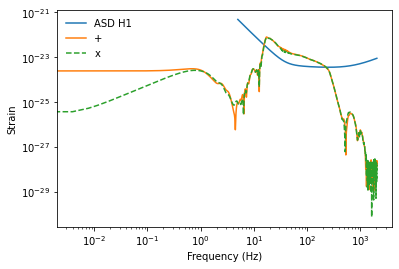

In [18]:
hp_td = h_td.real
hc_td = -h_td.imag

hp_fd = np.fft.rfft(hp_td) * fft_norm
hc_fd = np.fft.rfft(hc_td) * fft_norm
# h_frequencies = np.fft.rfftfreq(tlen) / fft_norm

fig, ax = plt.subplots(1)
ax.loglog(frequencies, np.sqrt(psd_dict[ifo_ref]), label=r'ASD %s' % ifo_ref)
ax.loglog(frequencies, np.abs(hp_fd), label='+')
ax.loglog(frequencies, np.abs(hc_fd), ls='--', label='x')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Strain')
ax.legend(loc='best', frameon=False)

Generate scalar waveform:

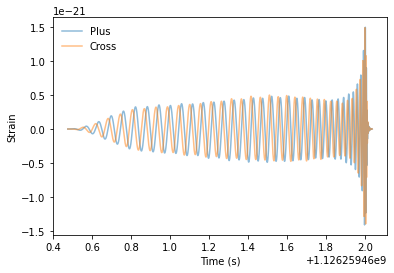

In [19]:
if t_inject is not None:
    
    # plot complex waveform
    fig, ax = plt.subplots(1)
    nplot = 10000
    ax.plot(times[t0idx:t0idx + len(h)], h_td.real[t0idx:t0idx + len(h)], label='Plus', alpha=0.5)
    ax.plot(times[t0idx:t0idx + len(h)], -h_td.imag[t0idx:t0idx + len(h)], label='Cross', alpha=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Strain')
    ax.legend(loc='best', frameon=False)
else:
    hb_td = 0.

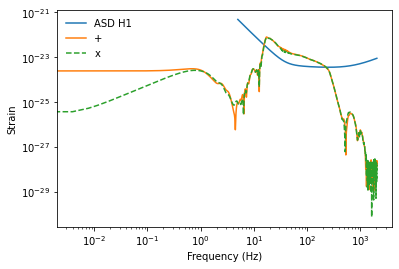

In [21]:
# h_frequencies = np.fft.rfftfreq(tlen) / fft_norm

fig, ax = plt.subplots(1)
ax.loglog(frequencies, np.sqrt(psd_dict[ifo_ref]), label=r'ASD %s' % ifo_ref)
ax.loglog(frequencies, np.abs(hp_fd), label='+')
ax.loglog(frequencies, np.abs(hc_fd), ls='--', label='x')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Strain')
ax.legend(loc='best', frameon=False)

## Detector projections

In [22]:
geo_gps_time = lal.LIGOTimeGPS(t_inject)
gmst = lal.GreenwichMeanSiderealTime(geo_gps_time)

for ifo, noise in psd_func_dict.items():
    detector = lal.cached_detector_by_prefix[ifo]
    # get antenna patterns
    Fp, Fc, Fb, _, _, _ = lal.ComputeDetAMResponseExtraModes(detector.response, ra, dec, psi, gmst)
    print(ifo, np.linalg.norm([Fp, Fc]), Fb)

H1 0.7340386373108094 -0.2376221567027857
L1 0.5661001602694028 0.43298350133564756
V1 0.6148949999302671 -0.3674007643109615
K1 0.8009552490444534 0.05149403641789793


In [23]:
geo_gps_time = lal.LIGOTimeGPS(t_inject)
gmst = lal.GreenwichMeanSiderealTime(geo_gps_time)

h_td_dict = {}
h_fd_dict = {}
data_td_dict = {}
tp_dict = {}
for ifo, noise in noise_td_dict.items():
    detector = lal.cached_detector_by_prefix[ifo]
    # get antenna patterns
    Fp, Fc, Fb, _, _, _ = lal.ComputeDetAMResponseExtraModes(detector.response, ra, dec, psi, gmst)
    # get time delay and align waveform
    # assume reference time corresponds to envelope peak
    timedelay = lal.TimeDelayFromEarthCenter(detector.location, ra, dec, geo_gps_time)
    
    fancy_timedelay = lal.LIGOTimeGPS(timedelay)
    timeshift = fancy_timedelay.gpsSeconds + 1e-9*fancy_timedelay.gpsNanoSeconds
    
    timeshift_vector = np.exp(-2.*1j*np.pi*timeshift*frequencies)
    
#     h_fd_dict[ifo] = (Fp*hp_fd + Fc*hc_fd + Fb*hb_fd)*timeshift_vector
    h_fd_dict[ifo] = (Fp*hp_fd + Fc*hc_fd)*timeshift_vector
    #h_fd_dict[ifo] = (Fb*hb_fd)*timeshift_vector
    print('WARNING: scalar only')
    h_td_dict[ifo] = np.fft.irfft(h_fd_dict[ifo]) / fft_norm
#     data_td_dict[ifo] = noise + h_td_dict[ifo]
    print('WARNING: no noise')
    data_td_dict[ifo] = h_td_dict[ifo]
    tp_dict[ifo] = t_inject + timedelay

Print times and delays with respect to reference detector. Note that the time delay follows the naming convention from `BayesPPUtils.py`, namely: `dt_12 = t2 - t1`. Here's the relevant code (currently l. 1006 [here](https://lscsoft.docs.ligo.org/lalsuite/lalinference/bayespputils_8py_source.html)):

```
for ifo1 in my_ifos:
    for ifo2 in my_ifos:
        if ifo1==ifo2: continue
        delay_time=ifo_times[ifo2]-ifo_times[ifo1]
    if injection:
        inj_delay=float(injection.get_end(ifo2[0])-injection.get_end(ifo1[0]))
    else:
        inj_delay=None
    time_delay=PosteriorOneDPDF(ifo1.lower()+ifo2.lower()+'_delay',delay_time,inj_delay)
```

In [24]:
for ifo in set(ifos) - {ifo_ref}:
    print('dt_%s%s:\t%.5e' % (ifo, ifo_ref, tp_dict[ifo_ref]-tp_dict[ifo]))

dt_L1H1:	6.98566e-03
dt_V1H1:	4.28128e-03
dt_K1H1:	-2.23804e-03


### SNRs

In [42]:
# compute SNRs
import numexpr as ne
import scipy.integrate as integrate

def innprod_fd(h1, h2, freq, Sn):
    over = ne.evaluate('h1*complex(h2.real, -h2.imag)/Sn')
    integral = integrate.simps(over, freq)
    return 4.*integral.real

freq_mask = (fmin <= frequencies) & (frequencies <= fmax)

print("IFO\tSNR_op\tSNR_mf\n---\t------\t------")

snr_op_dict = {}
snr_mf_dict = {}
data_fd_dict = {}
for ifo, h_fd in h_fd_dict.items():
    # compute optimal SNR
    snr_op = np.sqrt(innprod_fd(h_fd[freq_mask], h_fd[freq_mask],
                                frequencies[freq_mask],
                                psd_dict[ifo][freq_mask]))
    data_fd_dict[ifo] = np.fft.rfft(data_td_dict[ifo]) * fft_norm
    snr_mf = np.sqrt(innprod_fd(h_fd[freq_mask], data_fd_dict[ifo][freq_mask],
                                frequencies[freq_mask],
                                psd_dict[ifo][freq_mask]))
    print("%s\t%.2f\t%.2f" % (ifo, snr_op, snr_mf))
    snr_op_dict[ifo] = snr_op
    snr_mf_dict[ifo] = snr_mf

print
#print("Network SNR_op:\t %.2f" % np.linalg.norm(snr_op_dict.values()))
#print("Network SNR_mf:\t %.2f" % np.linalg.norm(snr_mf_dict.values()))

IFO	SNR_op	SNR_mf
---	------	------
H1	23.15	23.15
L1	42.18	42.18
V1	30.05	30.05
K1	5.02	5.02


<function print>

Individual mode SNRs:

In [43]:
from collections import OrderedDict

In [46]:
polks = ['plus', 'cross', 'tensor', 'scalar']

print("IFO\t"+'\t'.join(polks))
print('\t'.join(['------']*(len(polks)+1)))

mode_snr_dict = OrderedDict({k: OrderedDict({}) for k in polks})
for ifo, noise in noise_td_dict.items():
    detector = lal.cached_detector_by_prefix[ifo]
    # get antenna patterns
    Fp, Fc, Fb, _, _, _ = lal.ComputeDetAMResponseExtraModes(detector.response, ra, dec, psi, gmst)
    # get time delay and align waveform
    # assume reference time corresponds to envelope peak
    timedelay = lal.TimeDelayFromEarthCenter(detector.location, ra, dec, geo_gps_time)
    
    fancy_timedelay = lal.LIGOTimeGPS(timedelay)
    timeshift = fancy_timedelay.gpsSeconds + 1e-9*fancy_timedelay.gpsNanoSeconds
    
    timeshift_vector = 1#np.exp(-2.*1j*np.pi*timeshift*frequencies)
    
    wf = OrderedDict({
        'plus': Fp*hp_fd*timeshift_vector,
        'cross': Fc*hc_fd*timeshift_vector,
        'tensor': (Fp*hp_fd + Fc*hc_fd)*timeshift_vector,
        'scalar': Fb*hb_fd*timeshift_vector,
    })

    # compute optimal SNR
    snrs = {k: np.sqrt(innprod_fd(wf[k][freq_mask], wf[k][freq_mask],
                                frequencies[freq_mask],
                                psd_dict[ifo][freq_mask]))
            for k in polks}
    
    print(('%s\t' % ifo)+'\t'.join(['%.2f' % snrs[k] for k in polks])) 
    for k, v in snrs.items():
        mode_snr_dict[k][ifo] = v

# compute network SNR
#print('\t'.join(['------']*(len(polks)+1)))
#snrs = {k: np.linalg.norm(v.values()) for k,v in mode_snr_dict.items()}
#print('NET\t'+'\t'.join(['%.2f' % snrs[k] for k in polks])) 
# print
# print "Network SNR_op:\t %.2f" % np.linalg.norm(snr_op_dict.values())


IFO	plus	cross	tensor	scalar
------	------	------	------	------
H1	38.52	30.02	48.95	23.15
L1	35.28	13.88	37.97	42.18
V1	24.17	21.18	32.30	30.05
K1	27.32	45.18	52.90	5.02


In [47]:
for ifo, noise in noise_td_dict.items():
    detector = lal.cached_detector_by_prefix[ifo]
    # get antenna patterns
    Fp, Fc, Fb, _, _, _ = lal.ComputeDetAMResponseExtraModes(detector.response, ra, dec, psi, gmst)
    print(ifo, Fp, Fc, Fb)

H1 0.5731623319273625 -0.45858223071189524 -0.2376221567027857
L1 -0.524872237435652 0.21208141320336404 0.43298350133564756
V1 -0.45855181784430254 0.4096658288055385 -0.3674007643109615
K1 0.4064266373480424 -0.6901787445479796 0.05149403641789793


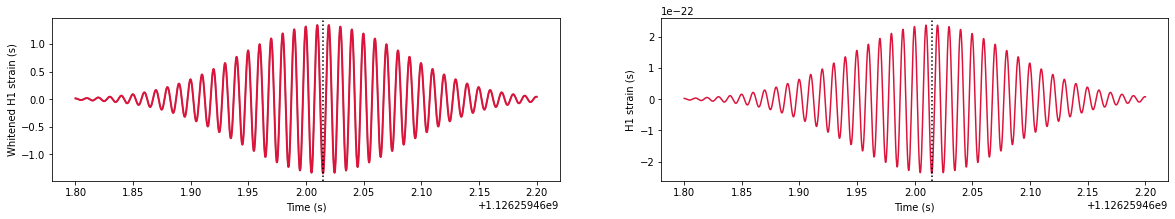

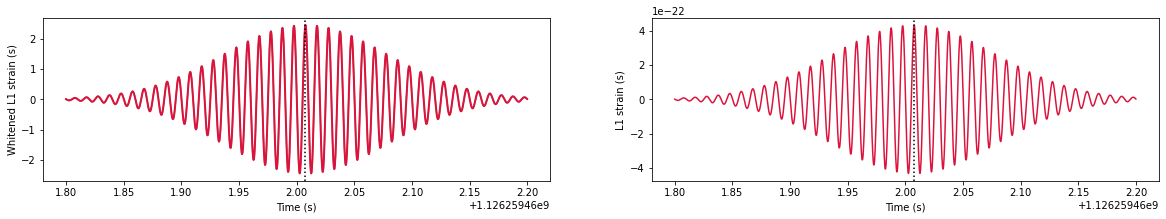

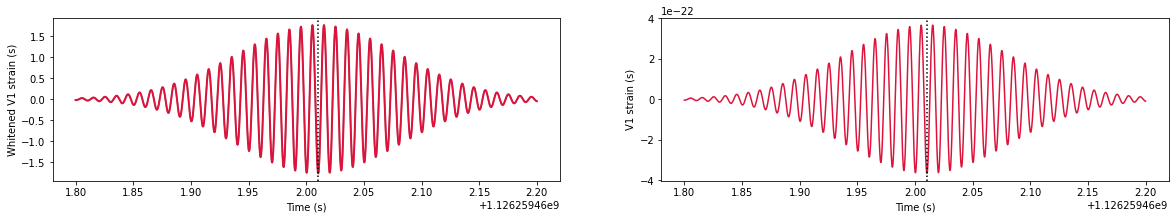

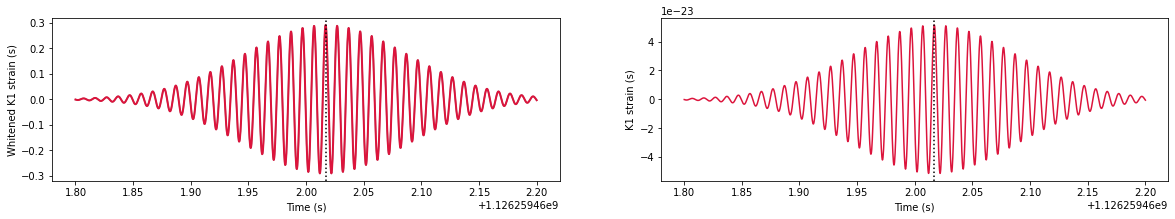

In [49]:
t_mask = (t_inject - 0.2 <= times) & (times <= t_inject + 0.2)
#  (4.*delta_f)
for ifo, data_fd in data_fd_dict.items():
    psd = psd_dict[ifo]
    psd[psd == 0] = np.inf
    data_fd_white = np.sqrt(4*delta_f/psd) * data_fd
     # TODO: why is this the right norm below?
    data_td_white = np.fft.irfft(data_fd_white)*np.sqrt(0.5*tlen)
    h_fd_white = np.sqrt(4*delta_f/psd) * h_fd_dict[ifo]
    h_td_white = np.fft.irfft(h_fd_white)*np.sqrt(0.5*tlen)
    fig, axs = plt.subplots(1,2, figsize=(20, 3))
    axs[0].plot(times[t_mask], data_td_white[t_mask], c='gray')
    axs[0].plot(times[t_mask], h_td_white[t_mask], lw=2, c='crimson')
    axs[1].plot(times[t_mask], h_td_dict[ifo][t_mask], c='crimson')
    for ax in axs:
        ax.axvline(tp_dict[ifo], ls=':', c='k')
        ax.set_xlabel('Time (s)')
    axs[0].set_ylabel('Whitened %s strain (s)' % ifo)
    axs[1].set_ylabel('%s strain (s)' % ifo)
    plt.show()


In [33]:
# # check time shift was done correctly
# for ifo in ifos:
#     detector = lal.cached_detector_by_prefix[ifo]
#     # get antenna patterns
#     Fp, Fc = lal.ComputeDetAMResponse(detector.response, ra, dec, psi, gmst)
#     # get time delay and align waveform
#     # assume reference time corresponds to envelope peak
#     timedelay = lal.TimeDelayFromEarthCenter(detector.location, ra, dec, geo_gps_time)
#     # FOR TESTING: make sure time delay is integer number of samples
#     timedelay -= timedelay % delta_t
    
#     fancy_timedelay = lal.LIGOTimeGPS(timedelay)
#     timeshift = fancy_timedelay.gpsSeconds + 1e-9*fancy_timedelay.gpsNanoSeconds
    
#     timeshift_vector = np.exp(-2.*1j*np.pi*timeshift*h_frequencies)
    
#     hp_fd_ifo = hp_fd*timeshift_vector
#     hc_fd_ifo = hc_fd*timeshift_vector
    
#     hp_td_ifo = np.fft.irfft(hp_fd_ifo) / fft_norm
#     hc_td_ifo = np.fft.irfft(hc_fd_ifo) / fft_norm
#     h_td_ifo = hp_td_ifo - 1j*hc_td_ifo
    
#     tp_ifo = times[np.argmax(np.abs(h_td_ifo))]
#     tp_ifo_target = t_inject + timedelay
#     print("%s peak time %.2e away from target" % (ifo, tp_ifo - tp_ifo_target))

## Export

In [34]:
# if export_path:
#     for ifo, data in data_td_dict.iteritems():
#         path = export_path % ifo
#         np.savetxt(path, np.array([times, data]).T)
#         print('Saved: %r' % path)

In [25]:
# export settings (doesn't save if False)
#from gwpy.timeseries import TimeSeries

# export_path = '{ifo}-{ifo}1_SCALARTENSOR_NONOISE-%i-%i.gwf' % (times[0], duration)
export_path = '{ifo}-{ifo}1_SCALAR_NONOISE-%i-%i.gwf' % (times[0], duration)

if export_path:
    from pycbc.types import TimeSeries
    from pycbc import frame
    for ifo, data in data_td_dict.items():
        d = TimeSeries(data, delta_t=delta_t,
                       epoch=times[0])
        path = export_path.format(ifo=ifo[0])
        frame.write_frame(path, ["%s1:INJ_STRAIN" % ifo[0]], [d])
        print("%s1:INJ_STRAIN" % ifo[0])
        print('Saved: %r' % path)

H1:INJ_STRAIN
Saved: 'H-H1_SCALAR_NONOISE-1126259334-256.gwf'
L1:INJ_STRAIN
Saved: 'L-L1_SCALAR_NONOISE-1126259334-256.gwf'
V1:INJ_STRAIN
Saved: 'V-V1_SCALAR_NONOISE-1126259334-256.gwf'
K1:INJ_STRAIN
Saved: 'K-K1_SCALAR_NONOISE-1126259334-256.gwf'
